## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests
from warnings import filterwarnings

filterwarnings("ignore")
%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре. 

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [6]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [8]:
pd.to_datetime(df.last_watch_dt).min()

Timestamp('2021-03-13 00:00:00')

In [9]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
349094,565123,15297,95,19020,75.0
4829001,666815,9079,61,11606,100.0
4608606,291917,10440,125,1838,10.0
415566,573707,12357,126,2278,30.0
3870863,733767,10942,55,127,2.0


In [11]:
df[df.user_id == 176549]

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,59,4250,72.0
3815,176549,15469,73,6318,100.0
4565,176549,9164,68,6024,100.0
18803,176549,12250,66,4109,58.0
209047,176549,5695,62,1434,25.0
...,...,...,...,...,...
5266742,176549,16166,118,22329,100.0
5287764,176549,4718,85,205,4.0
5347405,176549,4273,70,627,12.0
5397010,176549,7401,139,4846,63.0


Сделаем разбиение по времени

<Axes: >

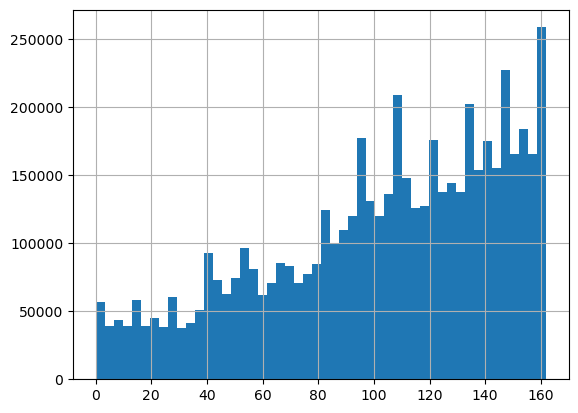

In [13]:
df.last_watch_dt.hist(bins=50)

In [14]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [15]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [17]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [18]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
41,985101,4566,125,420,34.0
77,222359,11237,4,1714,31.0
86,120361,15947,133,2444,47.0
112,490158,817,139,930,16.0
139,447592,1241,126,127,3.0


In [19]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

,user_id,train_interactions
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5..."
1,275,"[(12857, 77), (1033, 79), (10440, 79), (15297,..."
2,409,"[(10440, 106), (15297, 106), (5424, 108), (863..."
3,425,"[(10440, 142)]"
4,531,"[(3784, 133), (13865, 134), (4151, 134), (3734..."


In [20]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5...","[(12908, 159), (2836, 159), (12873, 159), (337..."
1,275,"[(12857, 77), (1033, 79), (10440, 79), (15297,...","[(13865, 155)]"
2,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]"
3,425,"[(10440, 142)]","[(12360, 156)]"
4,531,"[(3784, 133), (13865, 134), (4151, 134), (3734...","[(14488, 161)]"


In [21]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5...","[(12908, 159), (2836, 159), (12873, 159), (337...","[10440, 13510, 2028]"
1,275,"[(12857, 77), (1033, 79), (10440, 79), (15297,...","[(13865, 155)]","[10440, 13510, 2028]"
2,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[10440, 13510, 2028]"
3,425,"[(10440, 142)]","[(12360, 156)]","[10440, 13510, 2028]"
4,531,"[(3784, 133), (13865, 134), (4151, 134), (3734...","[(14488, 161)]","[10440, 13510, 2028]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$. 

In [24]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
) -> float:
    gt_items = np.asarray(gt_items)
    predictions = np.asarray(predictions)
    
    if gt_items.size == 0:
        return 0.0
    
    if topn is None:
        topn = len(predictions)
    k = min(topn, len(predictions))

    hits = np.isin(predictions[:k], gt_items).astype(np.float32)
    cumsum_hits = np.cumsum(hits)
    idxs = np.arange(1, k + 1)
    precision = cumsum_hits / idxs
    sum_precision = (precision * hits).sum()

    return float(sum_precision / min(k, len(gt_items)))

def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
) -> float:
    gt_items = np.asarray(gt_items)
    predictions = np.asarray(predictions)
    
    if gt_items.size == 0:
        return 0.0
    
    if topn is None:
        topn = len(predictions)
    k = min(topn, len(predictions))

    hits = np.isin(predictions[:k], gt_items)
    if not hits.any():
        return 0.0

    first_true_idx = np.argmax(hits)
    return float(1.0 / (first_true_idx + 1))


def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
) -> float:
    gt_items = np.asarray(gt_items)
    predictions = np.asarray(predictions)
    
    if gt_items.size == 0:
        return 0.0
    
    if topn is None:
        topn = len(predictions)
    k = min(topn, len(predictions))

    hits = np.isin(predictions[:k], gt_items)
    return float(hits.any())


Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит. 

In [26]:
from metric_tests import run_tests

In [27]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать. 

In [29]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    df['gt_items'] = df[gt_col].apply(lambda row: [x[0] for x in row])

    df['ap'] = df.apply(lambda row: ap_metric(row['gt_items'], row[model_preds]), axis=1)
    df['rr'] = df.apply(lambda row: rr_metric(row['gt_items'], row[model_preds]), axis=1)
    df['hr'] = df.apply(lambda row: hr_metric(row['gt_items'], row[model_preds]), axis=1)

    return {
        'map': round(df['ap'].mean(), 5),
        'mrr': round(df['rr'].mean(), 5),
        'hr':  round(df['hr'].mean(), 5)
    }

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [31]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.02974, 'mrr': 0.05368, 'hr': 0.054}

In [55]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,gt_items,ap,rr,hr,toppopular_recs
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5...","[(12908, 159), (2836, 159), (12873, 159), (337...","[10440, 13510, 2028]","[12908, 2836, 12873, 337, 6267, 5411, 10544, 1...",0.00,0.00,0.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,275,"[(12857, 77), (1033, 79), (10440, 79), (15297,...","[(13865, 155)]","[10440, 13510, 2028]",[13865],0.25,0.25,1.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[10440, 13510, 2028]",[16509],0.00,0.00,0.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,425,"[(10440, 142)]","[(12360, 156)]","[10440, 13510, 2028]",[12360],0.00,0.00,0.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,531,"[(3784, 133), (13865, 134), (4151, 134), (3734...","[(14488, 161)]","[10440, 13510, 2028]",[14488],0.00,0.00,0.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [58]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06616, 'mrr': 0.1207, 'hr': 0.2729}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [61]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2, max_date = 152):
        super().__init__()
        self.min_window = min_window
        self.max_date = max_date

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, timestamp in row[col]:
                if timestamp < (self.max_date -  self.min_window):
                    continue
                
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True


In [63]:
toppop_w = TopPopularWeighted(min_window=14)
toppop_w.fit(joined)
joined['toppopular_weighted_recs'] = toppop_w.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,gt_items,ap,rr,hr,toppopular_recs,toppopular_weighted_recs
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5...","[(12908, 159), (2836, 159), (12873, 159), (337...","[10440, 13510, 2028]","[12908, 2836, 12873, 337, 6267, 5411, 10544, 1...",0.00,0.00,0.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 10440, 15297, 7793, 3734, 13865, 4151, ..."
1,275,"[(12857, 77), (1033, 79), (10440, 79), (15297,...","[(13865, 155)]","[10440, 13510, 2028]",[13865],0.25,0.25,1.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 10440, 15297, 7793, 3734, 13865, 4151, ..."
2,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[10440, 13510, 2028]",[16509],0.00,0.00,0.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 10440, 15297, 7793, 3734, 13865, 4151, ..."
3,425,"[(10440, 142)]","[(12360, 156)]","[10440, 13510, 2028]",[12360],0.00,0.00,0.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 10440, 15297, 7793, 3734, 13865, 4151, ..."
4,531,"[(3784, 133), (13865, 134), (4151, 134), (3734...","[(14488, 161)]","[10440, 13510, 2028]",[14488],0.00,0.00,0.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 10440, 15297, 7793, 3734, 13865, 4151, ..."


In [65]:
evaluate_recommender(joined, model_preds='toppopular_weighted_recs')

{'map': 0.07073, 'mrr': 0.13079, 'hr': 0.3163}

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна. 

In [68]:
def evaluate_recommender_mod(df, model_preds, gt_col='test_interactions'):
    df = df.copy()  

    df.loc[:, 'gt_items'] = df[gt_col].apply(lambda row: [x[0] for x in row])

    df.loc[:, 'ap'] = df.apply(lambda row: ap_metric(row['gt_items'], row[model_preds]), axis=1)
    df.loc[:, 'rr'] = df.apply(lambda row: rr_metric(row['gt_items'], row[model_preds]), axis=1)
    df.loc[:, 'hr'] = df.apply(lambda row: hr_metric(row['gt_items'], row[model_preds]), axis=1)

    return round(df['ap'].mean(), 5), round(df['rr'].mean(), 5), round(df['hr'].mean(), 5)

In [70]:
metrics_comp = pd.DataFrame(columns = ['window', 'MAP@k', 'MRR@k', 'MHR@k'])
data_fm = joined[['user_id','train_interactions','test_interactions']]

for i in np.arange(2, 153):
    toppop_w = TopPopularWeighted(min_window=i)
    toppop_w.fit(data_fm)
    data_fm['predictions'] = toppop_w.predict(data_fm)
    maap, mrr, mhr = evaluate_recommender_mod(data_fm, model_preds='predictions')
    metrics_comp.loc[len(metrics_comp)] = [i, maap, mrr, mhr]

metrics_comp.head()

,window,MAP@k,MRR@k,MHR@k
0,2.0,0.07182,0.13191,0.3206
1,3.0,0.07311,0.13314,0.3308
2,4.0,0.07303,0.13398,0.3192
3,5.0,0.07194,0.13218,0.3192
4,6.0,0.07194,0.13218,0.3192


In [76]:
metrics_comp.sort_values(by=['MAP@k', 'MRR@k','MHR@k' ], ascending=False).iloc[:10]

,window,MAP@k,MRR@k,MHR@k
1,3.0,0.07311,0.13314,0.3308
2,4.0,0.07303,0.13398,0.3192
50,52.0,0.07282,0.13206,0.3041
51,53.0,0.07282,0.13206,0.3041
29,31.0,0.07259,0.13364,0.3192
30,32.0,0.07259,0.13364,0.3192
40,42.0,0.07252,0.13192,0.3022
41,43.0,0.07252,0.13192,0.3022
42,44.0,0.07252,0.13192,0.3022
43,45.0,0.07252,0.13192,0.3022


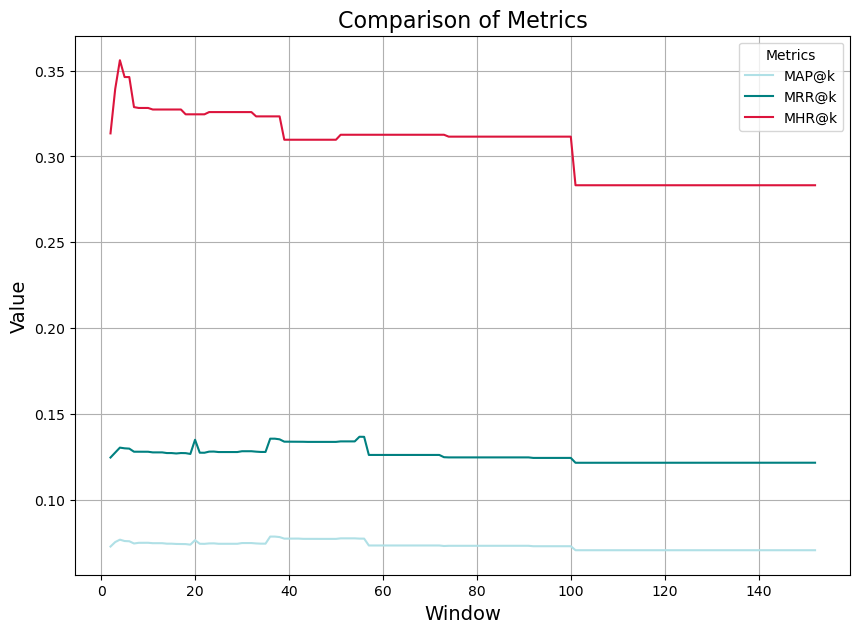

In [43]:
import seaborn as sns

plt.figure(figsize=(10, 7))

sns.lineplot(data=metrics_comp, x='window', y='MAP@k', label='MAP@k', color = 'powderblue')
sns.lineplot(data=metrics_comp, x='window', y='MRR@k', label='MRR@k', color = 'teal')
sns.lineplot(data=metrics_comp, x='window', y='MHR@k', label='MHR@k', color = 'crimson')

plt.legend(title="Metrics") 
plt.xlabel("Window", fontsize = 14)         
plt.ylabel("Value", fontsize = 14)          
plt.title("Comparison of Metrics", fontsize=16) 
plt.grid(True)

plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:**

Оптимальный размер окна для расчёта популярности рекомендаций находится в диапазоне 3-50 дней, так как он обеспечивает баланс между актуальностью и стабильностью рекомендаций. При слишком малом окне, в которое включено меньше 3 дней, рекомендации ориентируются только на краткосрочные тренды, что может приводить к нестабильности. При слишком большом окне рекомендации начинают учитывать устаревшую популярность, снижая точность. График показывает, что метрики `MHR@k`, `MRR@k` и `MAP@k` достигают максимума в этом диапазоне, после чего начинают снижаться, подтверждая важность выбора правильного временного интервала.

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике. 

In [50]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

In [62]:
metrics_comp_k = pd.DataFrame(columns = ['k', 'MAP@k', 'MRR@k', 'MHR@k'])

toppop = TopPopular()
toppop.fit(data_fm)

for i in np.arange(1, 101):
    data_fm['predictions'] = toppop.predict(data_fm, topn=i)
    maap, mrr, mhr = evaluate_recommender_mod(data_fm, model_preds='predictions')
    metrics_comp_k.loc[len(metrics_comp_k)] = [i, maap, mrr, mhr]

metrics_comp_k.head()

,k,MAP@k,MRR@k,MHR@k
0,1.0,0.05120,0.05120,0.0512
1,2.0,0.05605,0.08065,0.1101
2,3.0,0.06281,0.10118,0.1717
3,4.0,0.06470,0.10868,0.2017
4,5.0,0.06646,0.11400,0.2283


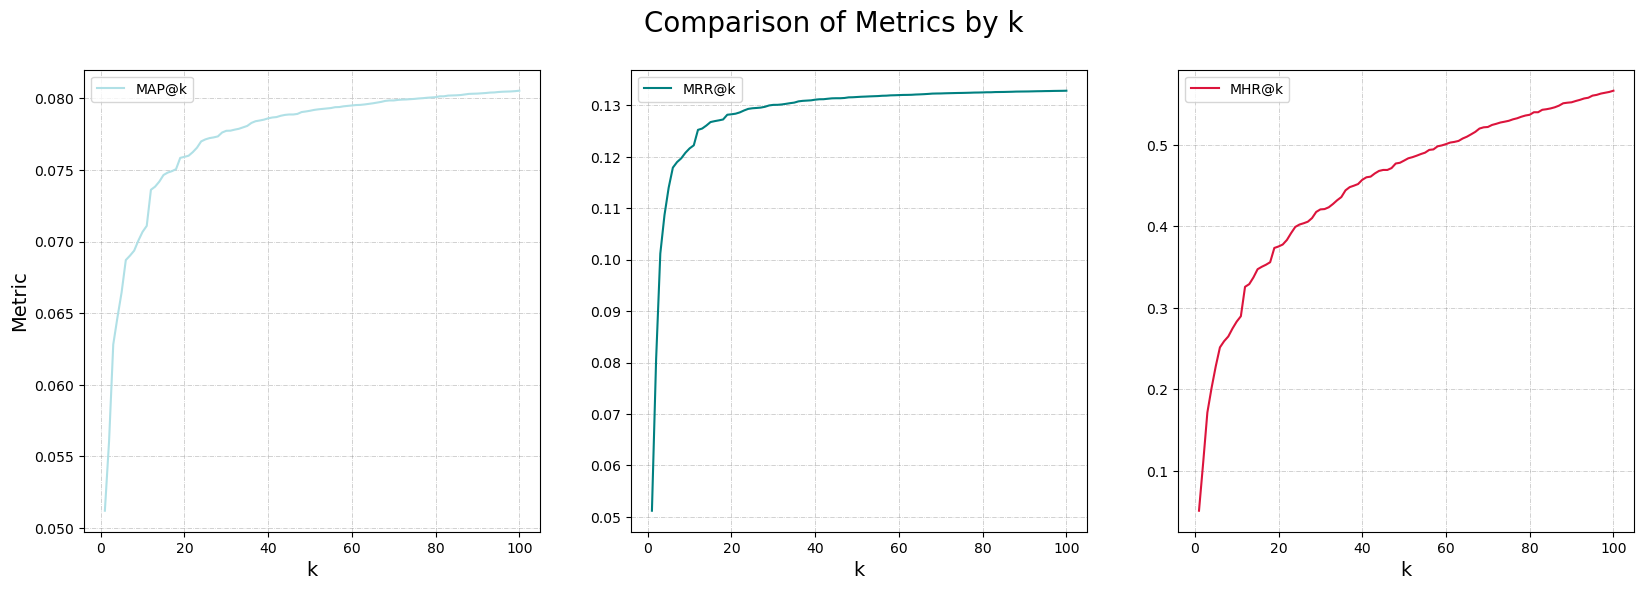

In [67]:
fig, axes = plt.subplots(1, 3, figsize = (20,6))

sns.lineplot(data=metrics_comp_k, x='k', y='MAP@k', label='MAP@k', color = 'powderblue', ax=axes[0])
sns.lineplot(data=metrics_comp_k, x='k', y='MRR@k', label='MRR@k', color = 'teal', ax = axes[1])
sns.lineplot(data=metrics_comp_k, x='k', y='MHR@k', label='MHR@k', color = 'crimson', ax = axes[2])

axes[0].set_ylabel('Metric', fontsize=14)

for i in np.arange(1,3):
    axes[i].set_ylabel('')


for ax in axes:
    ax.set_xlabel('k', fontsize=14)
    ax.grid(color="gray", linestyle= "-.", linewidth=0.5, alpha=0.5)

fig.suptitle("Comparison of Metrics by k", fontsize=20)

plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:**

- Все три метрики `MAP@k`, `MRR@k` и `MHR@k` являются монотонно неубывающими. Это связано с тем, что алгоритм TopPopular рекомендует самые популярные фильмы, а увеличение k добавляет новые фильмы в список рекомендаций, повышая вероятность нахождения релевантного контента.

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:**

* `MAP@k` – растет на малых k, затем выходит на плато. Важна для случаев, когда пользователи выбирают фильм из ограниченного списка.
* `MRR@k` – резкко растет при малых k, затем стабилизируется. Является ключевой метрикой для первых позиций в выдаче.
* `MHR@k` – постоянно растет. Важна в случае, когда пользователи долго листают каталог в поиске фильма.

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:**

- `MAP@k` и `MRR@k` выходят на плато, так как популярные фильмы быстро охватывают большинство предпочтений пользователей, а добавление новых фильмов уже незначительно влияет на точность.
- `MHR@k` постоянно растет, так как чем больше k, тем выше шанс, что фильм, который интересен пользователю, окажется в рекомендациях.

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей. 

In [84]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


In [92]:
items[items.title == 'Жмурки']

,item_id,title
4706,10884,Жмурки


Пример:

1917


<Axes: >

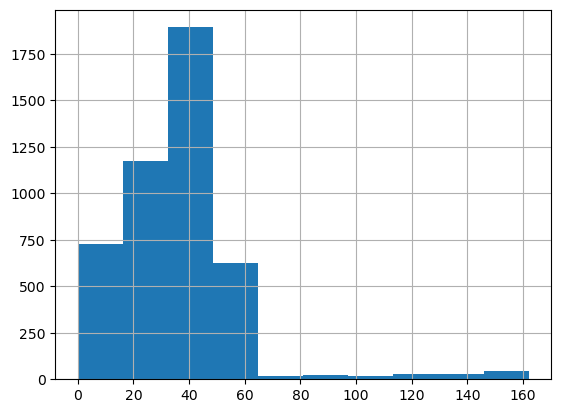

In [74]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной. 

Добавьте 5 своих примеров ниже. Опишите, как вы их искали. 

Что скрывает вода


<Axes: >

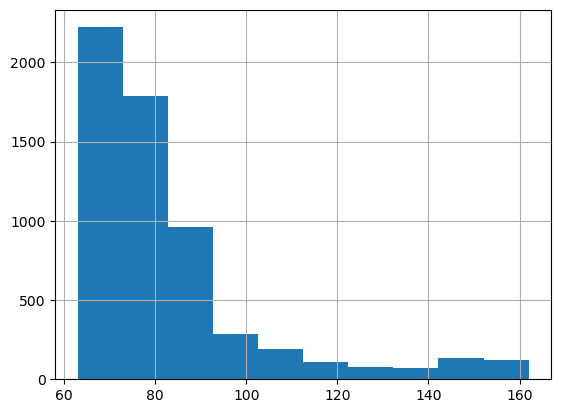

In [77]:
sampled_id = 10077

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

- Фильм "*Что скрывает вода*" вышел 11 февраля 2021 года в России. Вероятно какое-то время он сохранял популярность с того времени. Однако где-то к июню 2021 популярность довольно сильно просела. Скорее всего дело в том, что большинство пользователей, которые хотели посмотреть данный фильм к этому моменту времени уже посмотрели его и не имели желания пересматривать его. Также скорее всего из-за жанра, а также из-за давности даты выхода, вероятно, что онлайн кинотеатр перестал продвигать данный фильмю

Король Лев


<Axes: >

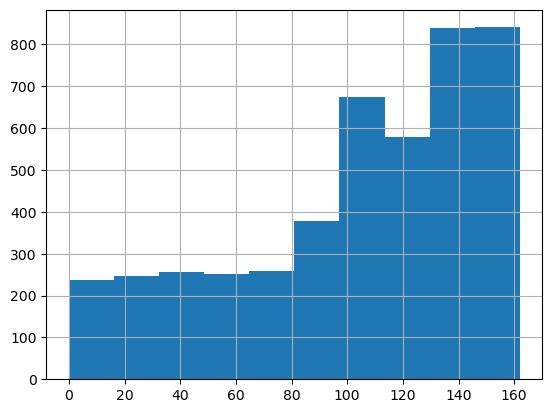

In [79]:
sampled_id = 2956

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

- Для фильма "*Король Лев*" целевой аудиторией являются дети. Видно, что его популярность подскакивает примерно с началом летнего сезона, когда у детей начинаются летние каникулы, что говорит о сезонной популярности данного фильма. Однако вне сезона фильм также продолжают смотреть, так как у него нет привязки к каким либо событиям.

Брат 2


<Axes: >

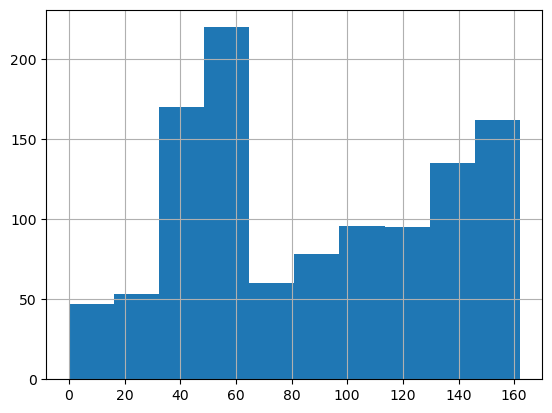

In [96]:
sampled_id = 4474

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

- Для фильма “*Брат 2*” популярность держится довольно стабильно, но в разные периоды возникают всплески просмотров. Это может быть связано с упоминаниями в медиа, праздниками или ростом интереса к культовому российскому кино.

Тор: Царство тьмы


<Axes: >

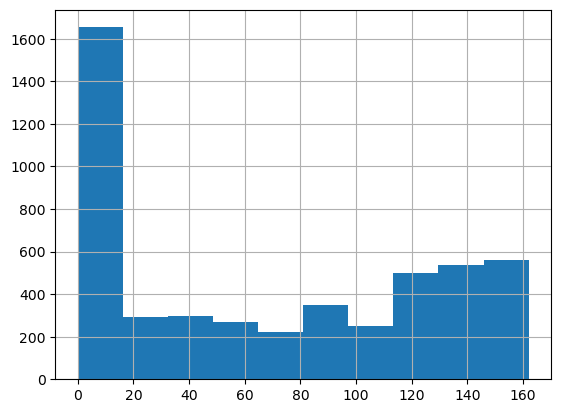

In [258]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

- Фильм “*Тор: Царство тьмы*” изначально имел всплеск популярности, вероятно из-за того, что онлайн кинотеатр купил лицензию на данный фильм и начал его продвигать, а затем произошло снижение популярности, вероятно, так как фильм довольно старый. Через некоторое время популярность снова возросла и это могло быть вызвано выходом нового фильма из франшизы Marvel, что привело к пересмотру старых частей. Также фильм мог попасть в акционные подборки или снова начать продвигаться кинотеатром.

Немцы


<Axes: >

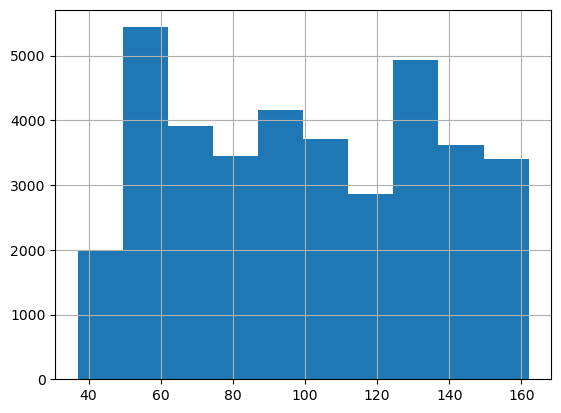

In [239]:
sampled_id = np.random.choice(popular_items)

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

- "*Немцы*" - это сериал, который вышел эксклюзивно на платформе **KION**. Из-за этого вероятно, что данный онлайн кинотеатр активно продвигал этот сериал, что видно по его стабильно высокой популярности.

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках. 

In [105]:
def filter_column(df, col, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    data = df.copy()
    
    counts = data[col].value_counts()
    values_mmf = counts[counts >= min_freq].index

    return data[data[col].isin(values_mmf)]

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    while True:
        old_shape = df.shape
        for col in cols:
            df = filter_column(df, col, min_freq)
        new_shape = df.shape
        if new_shape == old_shape:
            break
    return df

filtered_train = filter_dataframe(train_df, ['item_id', 'user_id'], min_freq=5)

item2id = {k:v for v, k in enumerate(filtered_train.item_id.unique())}
user2id = {k:v for v, k in enumerate(filtered_train.user_id.unique())}
id2item = {k:v for v, k in item2id.items()}
id2user = {k:v for v, k in user2id.items()}

In [107]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.user_id.unique())}

    id2item = {k:v for v, k in item2id.items()}
    id2user = {k:v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df

filtered_train = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
723421,4619,65,138,10312,75.0
1789576,2735,1087,148,43,0.0
2495457,1960,357,137,2376,9.0
2052439,65,71,144,22518,100.0
1079332,1212,286,102,4058,77.0


In [109]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<5908x3052 sparse matrix of type '<class 'numpy.float64'>'
	with 104361 stored elements in COOrdinate format>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра. 

In [112]:
users_items_data = pd.DataFrame(columns = ['min_freq', 'n_users', 'n_items'])

for i in np.arange(1, 25):
    n_u = len(filter_dataframe(train_df, ['item_id', 'user_id'], min_freq=i).user_id.unique())
    n_i = len(filter_dataframe(train_df, ['item_id', 'user_id'], min_freq=i).item_id.unique())
    users_items_data.loc[len(users_items_data)] = [i, n_u, n_i]

users_items_data.head()

,min_freq,n_users,n_items
0,1,10000,6621
1,2,8537,4711
2,3,7499,3878
3,4,6627,3395
4,5,5908,3052


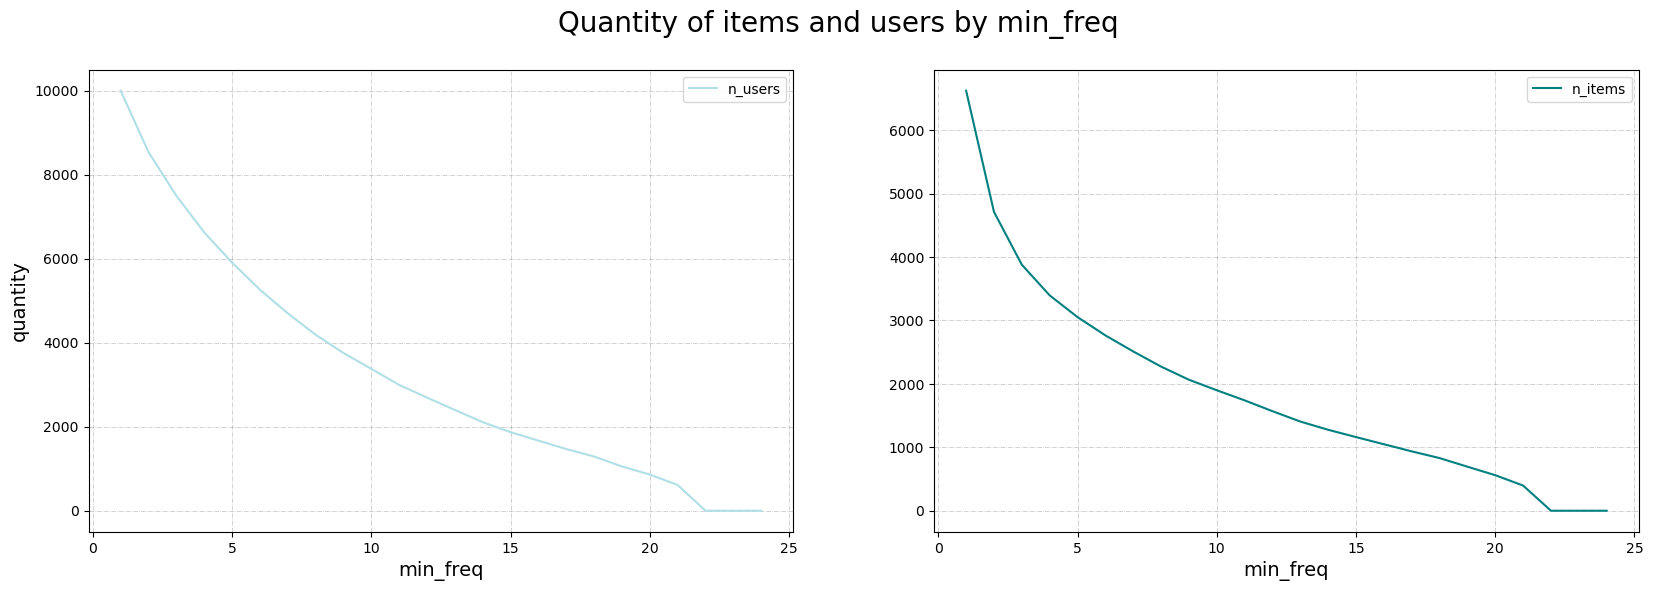

In [118]:
fig, axes = plt.subplots(1, 2, figsize = (20,6))

sns.lineplot(data=users_items_data, x='min_freq', y='n_users', label='n_users', color = 'powderblue', ax=axes[0])
sns.lineplot(data=users_items_data, x='min_freq', y='n_items', label='n_items', color = 'teal', ax = axes[1])

axes[0].set_ylabel('quantity', fontsize=14)

for i in np.arange(1,2):
    axes[i].set_ylabel('')


for ax in axes:
    ax.set_xlabel('min_freq', fontsize=14)
    ax.grid(color="gray", linestyle= "-.", linewidth=0.5, alpha=0.5)

fig.suptitle("Quantity of items and users by min_freq", fontsize=20)

plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k. 

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [122]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=1000):

 # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)
    
    return B

w = fit_ease(matrix, reg_weight = 10000)

CPU times: user 3.84 s, sys: 75.1 ms, total: 3.92 s
Wall time: 517 ms


In [124]:
w.shape

(3052, 3052)

Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [127]:
def get_preds(x, item2id, id2item, k=100):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    # Составляем вектор интеракций человека
    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]#.toarray()
    preds[encoded==1] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:k]
    
    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, k =100))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,gt_items,ap,rr,hr,toppopular_recs,toppopular_weighted_recs,ease_preds
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5...","[(12908, 159), (2836, 159), (12873, 159), (337...","[10440, 13510, 2028]","[12908, 2836, 12873, 337, 6267, 5411, 10544, 1...",0.000000,0.000000,0.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 10440, 15297, 7793, 3734, 13865, 4151, ...","[9728, 7571, 15297, 10440, 16166, 3734, 13865,..."
1,275,"[(12857, 77), (1033, 79), (10440, 79), (15297,...","[(13865, 155)]","[10440, 13510, 2028]",[13865],0.166667,0.166667,1.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 10440, 15297, 7793, 3734, 13865, 4151, ...","[13865, 9728, 4151, 10440, 15297, 3734, 142, 2..."
2,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[10440, 13510, 2028]",[16509],0.000000,0.000000,0.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 10440, 15297, 7793, 3734, 13865, 4151, ...","[13865, 9728, 4151, 10440, 15297, 3734, 142, 2..."
3,425,"[(10440, 142)]","[(12360, 156)]","[10440, 13510, 2028]",[12360],0.000000,0.000000,0.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 10440, 15297, 7793, 3734, 13865, 4151, ...","[15297, 9728, 13865, 4151, 2657, 3734, 142, 99..."
4,531,"[(3784, 133), (13865, 134), (4151, 134), (3734...","[(14488, 161)]","[10440, 13510, 2028]",[14488],0.000000,0.000000,0.0,"[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 10440, 15297, 7793, 3734, 13865, 4151, ...","[10440, 15297, 9728, 4880, 13865, 3734, 4151, ..."


In [129]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06616, 'mrr': 0.1207, 'hr': 0.2729}

In [95]:
evaluate_recommender(joined, model_preds='ease_preds')

{'map': 0.09865, 'mrr': 0.16879, 'hr': 0.6179}

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:**

- Алгоритм `EASE` лучше `TopPopular` по всем метрикам, так как учитывает персональные предпочтения пользователей, а не просто рекомендует самые популярные фильмы.

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации. 

In [134]:
class EASE:
    def __init__(self, reg_weight=100, k = 100):

        self.reg_weight = reg_weight
        self.W = None 
        self.k = k

    def fit(self, X):
        G = X.T @ X

        G += self.reg_weight * sps.identity(G.shape[0])

        G = G.todense()

        P = np.linalg.inv(G)
        B = P / (-np.diag(P))

        np.fill_diagonal(B, 0.)

        self.W = B
        return self

    def predict(self, x, item2id, id2item):

        user_items = [t[0] for t in x]
        encoded = [item2id[t] for t in user_items if t in item2id]

        vector = np.zeros(len(item2id))
        vector[encoded] = 1

        vector = sps.csr_matrix(vector)

        preds = np.array(vector.dot(self.W))[0]#.toarray()
        preds[encoded==1] = -np.inf

        ranks = np.argsort(-preds)
        topk_indices = ranks[:self.k]
        decoded = [id2item[idx] for idx in topk_indices]

        return decoded

ease_recsys = EASE(reg_weight=300, k = 100)
ease_recsys.fit(matrix)

joined['ease_preds'] = joined.train_interactions.apply(lambda x: ease_recsys.predict(x, item2id, id2item))

In [135]:
metrics_rw = pd.DataFrame(columns = ['reg_weight', 'MAP@k', 'MRR@k', 'MHR@k'])

data_fm = joined[['user_id','train_interactions','test_interactions']]

reg_weights = np.logspace(-2, 4, 50)

for i in reg_weights:
    weight = i
    ease_recsys = EASE(reg_weight=weight)
    ease_recsys.fit(matrix)
    temp_data = data_fm.copy()
    temp_data['predictions'] = temp_data.train_interactions.apply(lambda x: ease_recsys.predict(x, item2id, id2item))
    ap, rr, hr = evaluate_recommender_mod(temp_data, model_preds='predictions')
    metrics_rw.loc[len(metrics_rw)] = [i, ap, rr, hr]

In [140]:
metrics_rw.sort_values(by=['MAP@k', 'MRR@k', 'MHR@k'], ascending=False).iloc[:10]

,reg_weight,MAP@k,MRR@k,MHR@k
49,10000.000000,0.09232,0.16332,0.6049
48,7543.120063,0.09155,0.16216,0.6063
47,5689.866029,0.09127,0.16176,0.6070
46,4291.934260,0.09048,0.16037,0.6084
45,3237.457543,0.08961,0.15917,0.6103
44,2442.053095,0.08882,0.15811,0.6098
43,1842.069969,0.08798,0.15687,0.6070
42,1389.495494,0.08681,0.15491,0.6029
41,1048.113134,0.08583,0.15338,0.5989
40,790.604321,0.08483,0.15157,0.5955


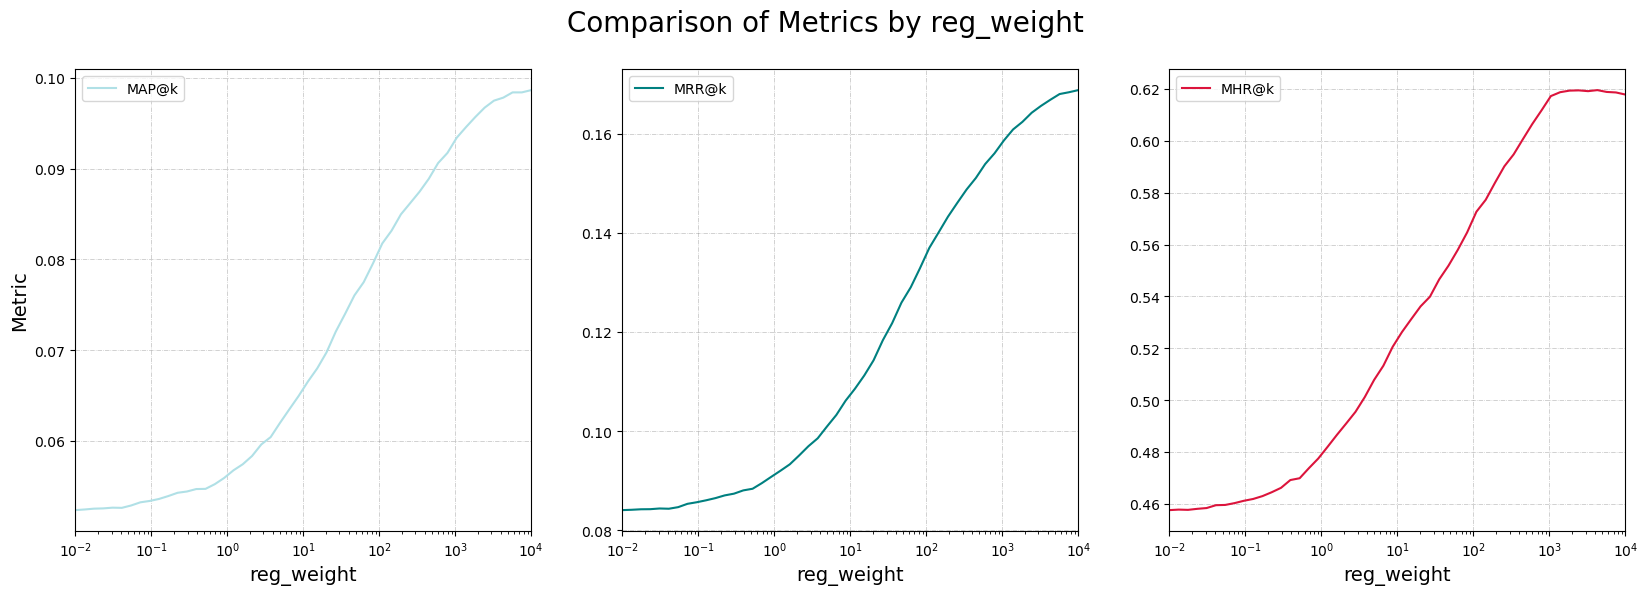

In [101]:
fig, axes = plt.subplots(1, 3, figsize = (20,6))

sns.lineplot(data=metrics_rw, x='reg_weight', y='MAP@k', label='MAP@k', color = 'powderblue', ax=axes[0])
sns.lineplot(data=metrics_rw, x='reg_weight', y='MRR@k', label='MRR@k', color = 'teal', ax = axes[1])
sns.lineplot(data=metrics_rw, x='reg_weight', y='MHR@k', label='MHR@k', color = 'crimson', ax = axes[2])

axes[0].set_ylabel('Metric', fontsize=14)

for i in np.arange(1,3):
    axes[i].set_ylabel('')


for ax in axes:
    ax.set_xlabel('reg_weight', fontsize=14)
    ax.grid(color="gray", linestyle= "-.", linewidth=0.5, alpha=0.5)
    ax.set_xscale('log')
    ax.set_xlim(1e-2, 1e4)

fig.suptitle("Comparison of Metrics by reg_weight", fontsize=20)
plt.xscale('log')

plt.show()

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим? 


**Ответ:**

- Лучшим значением гиперпараметра является `reg_weight` ≈ $10^3$ – $10^4$. В частности, если провести сортировку по всем метрикам, то лучшим оказывается параметр  $10^4$.

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:**
- `EASE` сильно зависит от регуляризации – на малых значениях `reg_weight` (примерно от $10^-2$ до $10^0$) модель показывает низкие метрики, так как она переобучается на шуме.
- Рост качества начинается с `reg_weight` ≈ $10^1$ и это говорит о том, что правильная настройка регуляризации критически важна для работы EASE.
- `MHR@k` быстрее выходит на плато – это означает, что модель уже покрывает основную часть релевантных элементов при k-рекомендациях, а дальнейшая регуляризация больше влияет на точность ранжирования, на которую указывают метрики `MAP@k` и `MRR@k`.
- Логарифмическая шкала параметра – показывает, что небольшие изменения в низких значениях (от $10^0$ до $10^2$) дают сильный эффект, но после $10^3$ улучшение замедляется.

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы. 

In [405]:
metrics_topk_ease = pd.DataFrame(columns = ['topk', 'min_freq', 'MAP@k', 'MRR@k', 'MHR@k'])

data_fm = joined[['user_id','train_interactions','test_interactions']]

for i in np.arange(1, 22):
    temp_train = filter_dataframe(train_df, ['item_id', 'user_id'], min_freq=i)
    
    temp_item2id = {k:v for v, k in enumerate(temp_train.item_id.unique())}
    temp_user2id = {k:v for v, k in enumerate(temp_train.user_id.unique())}
    temp_id2item = {k:v for v, k in temp_item2id.items()}
    temp_id2user = {k:v for v, k in temp_user2id.items()}

    temp_train = df_encode(temp_train)
    
    temp_matrix = sps.coo_matrix(
        (np.ones(temp_train.shape[0]), (temp_train['user_id'], temp_train['item_id'])),
        shape=(len(temp_user2id), len(temp_item2id)),
    )
    for j in np.arange(1, 101):
        ease_recsys = EASE(reg_weight=10000, k = j)
        ease_recsys.fit(temp_matrix)
        temp_data = data_fm.copy()
        temp_data['predictions'] = temp_data.train_interactions.apply(lambda x: ease_recsys.predict(x, temp_item2id, temp_id2item))
        ap, rr, hr = evaluate_recommender_mod(temp_data, model_preds='predictions')
        metrics_topk_ease.loc[len(metrics_topk_ease)] = [j ,i, ap, rr, hr]

In [406]:
metrics_topk_ease.head()

,topk,min_freq,MAP@k,MRR@k,MHR@k
0,1.0,1.0,0.09270,0.09270,0.0927
1,2.0,1.0,0.08265,0.12035,0.1480
2,3.0,1.0,0.08062,0.13242,0.1842
3,4.0,1.0,0.08016,0.13829,0.2077
4,5.0,1.0,0.08053,0.14219,0.2272


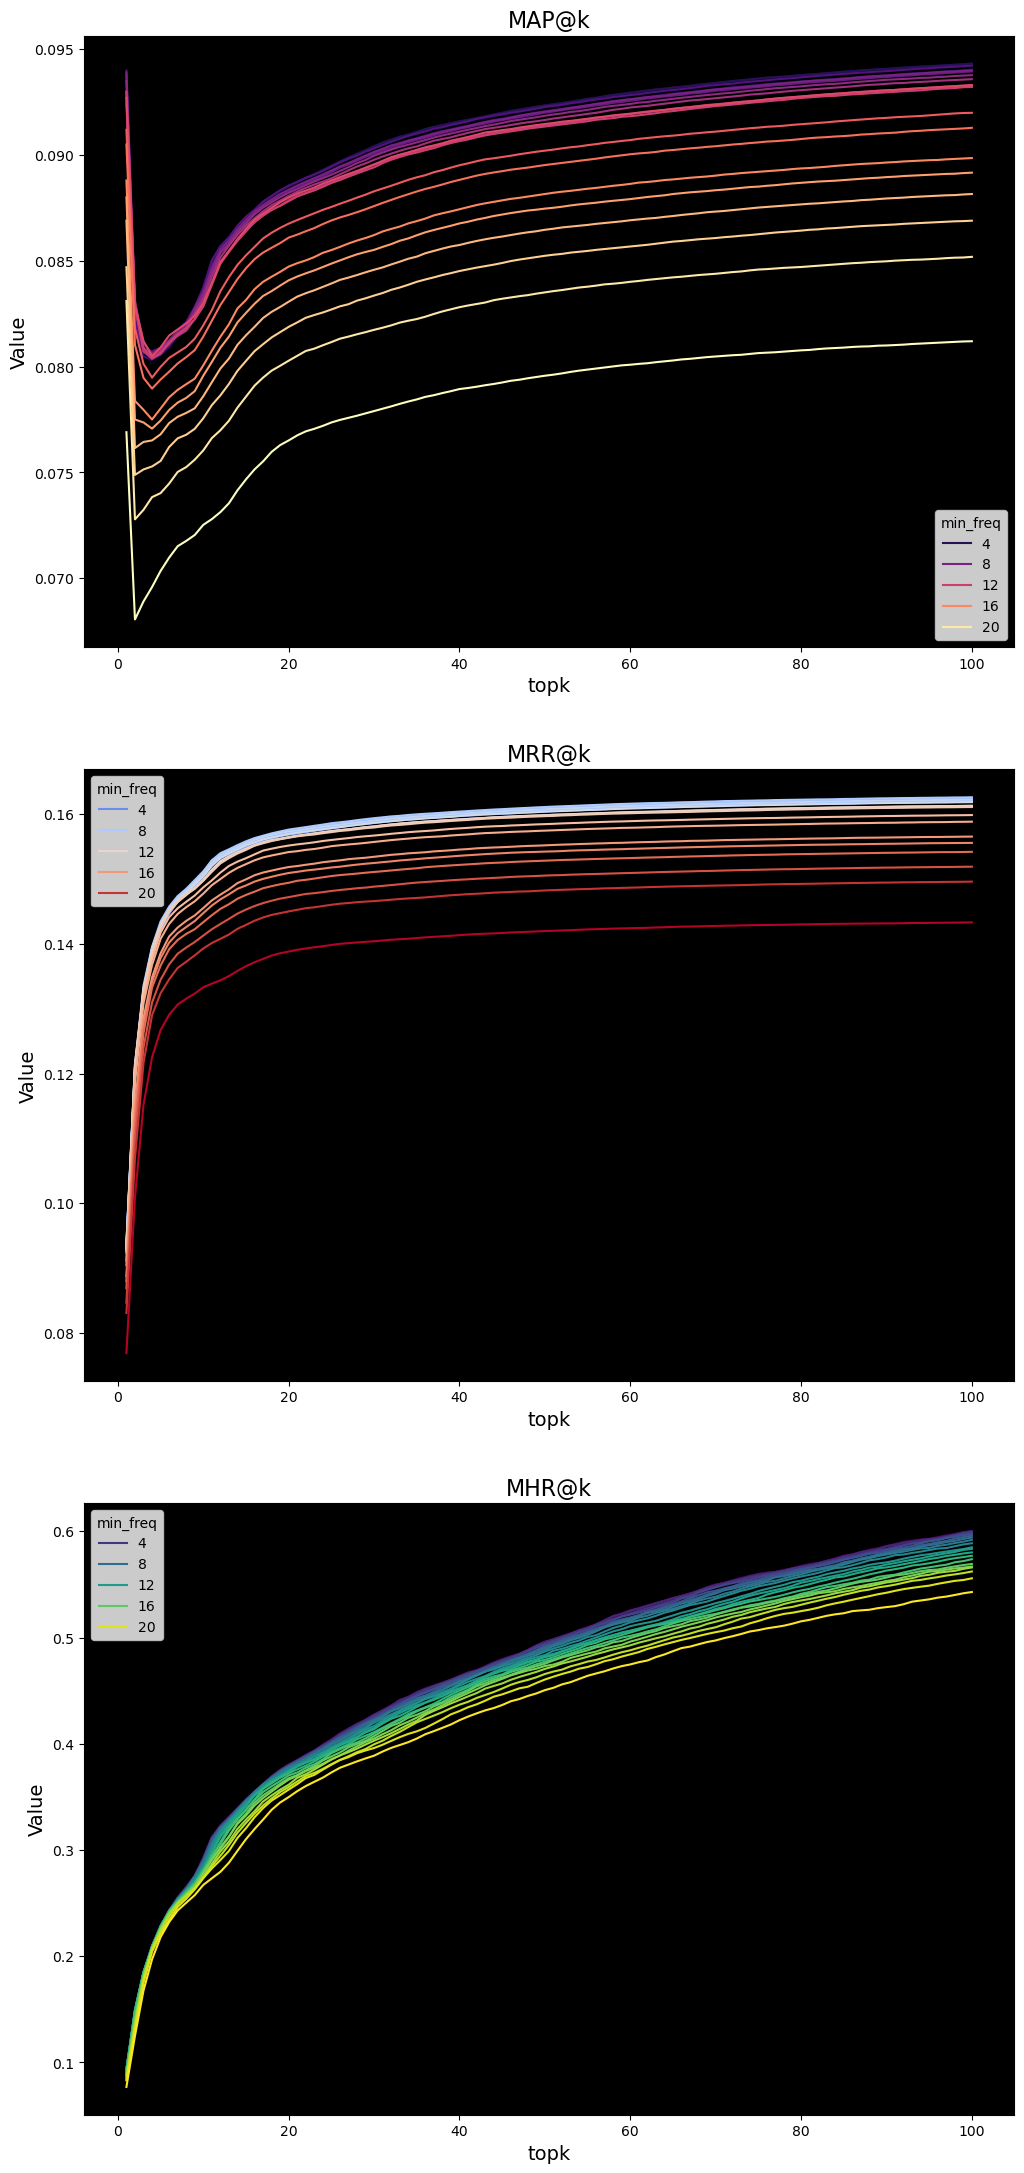

In [495]:
fig, axes = plt.subplots(3, 1, figsize = (12,27))
metrics = ['MAP@k', 'MRR@k', 'MHR@k']
sns.lineplot(data=metrics_topk_ease, x='topk', y='MAP@k', ax=axes[0], hue='min_freq', palette='magma')
sns.lineplot(data=metrics_topk_ease, x='topk', y='MRR@k', ax = axes[1], hue='min_freq', palette = 'coolwarm')
sns.lineplot(data=metrics_topk_ease, x='topk', y='MHR@k', ax = axes[2], hue='min_freq', palette = 'viridis')

axes[0].set_ylabel('Metric', fontsize=14)

for i in np.arange(0,3):
    axes[i].set_title(metrics[i], fontsize = 16)
    axes[i].set_ylabel('Value', fontsize=14)
    axes[i].set_xlabel('topk', fontsize=14)
    axes[i].set_facecolor("black")


plt.show()

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:**

- В графике `MAP@k` наблюдается провал на малых значениях **k**, что связано с тем, что на первых позициях ранжирования модель может допускать ошибки, особенно если **k** слишком мало для учета всех релевантных рекомендаций. В этом случае несколько нерелевантных элементов в начале списка могут существенно повлиять на итоговое значение `MAP@k`. Однако с ростом **k** метрика начинает увеличиваться, так как вероятность включения релевантных рекомендаций в топовые позиции возрастает, и влияние отдельных ошибок становится менее критичным.
- Рассматривая влияние `min_freq`, можно отметить, что более низкие значения фильтра позволяют модели учитывать больше редких айтемов, что приводит к улучшению `MAP@k`. Это подтверждает вывод из лекции.
- На графике `MRR@k` можно заметить, что при меньших значениях `min_freq` модель лучше справляется с ранжированием релевантных элементов, особенно в начале списка рекомендаций. Это означает, что более мягкая фильтрация позволяет `EASE` эффективнее находить персонализированные фильмы и предлагать их в топе. Однако при жестком фильтре `(min_freq = 22)` первые позиции занимают более популярные, но не всегда наиболее релевантные рекомендации, что снижает значение `MRR@k`.
- График `MHR@k` демонстрирует закономерный рост с увеличением **k**, поскольку при расширении списка рекомендаций шанс найти хотя бы один релевантный фильм возрастает. Видно, что при меньших значениях `min_freq` метрика выше, так как модель не ограничивает себя только популярными элементами, а включает в рекомендации более широкий спектр фильмов. Это делает рекомендации более разнообразными и релевантными.
- 

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций. 

In [217]:
movies = np.random.choice(list(item2id.keys()), size=10, replace=False)

In [275]:
def get_topk_recs_ease(movie, k=5):
    preds = get_preds([(movie, i)], item2id, id2item, k = k)
    print(f'Фильм: {items[items.item_id == movie].title.values[0]}\n')
    print('Топ-5 рекомендаций от EASE:')
    for j, g in enumerate(preds):
        print(f'   {j+1}. {items[items.item_id == g].title.values[0]}')
    print('\n')

In [283]:
movies = np.random.choice(list(item2id.keys()), size=10, replace=False)

for i in movies:
    get_topk_recs_ease(i)
    

Фильм: Танцующая в темноте

Топ-5 рекомендаций от EASE:
   1. Маша
   2. Таинственный сад
   3. Проклятие ведьмы
   4. Клиника счастья
   5. Тело Христово


Фильм: Посылка

Топ-5 рекомендаций от EASE:
   1. Подслушано
   2. Цвет из иных миров
   3. Хрустальный
   4. Взаперти
   5. Аферистка


Фильм: Застава

Топ-5 рекомендаций от EASE:
   1. Девятаев
   2. Хрустальный
   3. Гнев человеческий
   4. Пальмира
   5. Афера


Фильм: Пандемия

Топ-5 рекомендаций от EASE:
   1. Гнев человеческий
   2. Девятаев
   3. Дочь волка
   4. Поступь хаоса
   5. День мертвецов: Злая кровь


Фильм: С вещами на вылет!

Топ-5 рекомендаций от EASE:
   1. Хрустальный
   2. Любовь
   3. От семьи не убежишь
   4. Куриоса
   5. Девятаев


Фильм: Давай сразимся, призрак

Топ-5 рекомендаций от EASE:
   1. Хрустальный
   2. Стендап под прикрытием
   3. Маленький воин
   4. Дочь волка
   5. Гоблин (Демон)


Фильм: Звёздные войны: Пробуждение силы

Топ-5 рекомендаций от EASE:
   1. Звёздные войны: Скайуокер. Восход


In [285]:
get_topk_recs_ease(7400, k=10)

Фильм: Груз 200

Топ-5 рекомендаций от EASE:
   1. Хрустальный
   2. Клиника счастья
   3. Белый снег
   4. Гнев человеческий
   5. Маша
   6. Кочегар
   7. Великий уравнитель 2
   8. Значит, война
   9. Анон
   10. Шугалей




Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**

- Некоторые рекомендации выглядят довольно хорошо. Например, для “Звёздные войны: Пробуждение силы” предложены другие части серии фильмов, а для фильма “Брат” предлагается его сиквел  “Брат 2”.
- Есть и весьма странные рекомендации. Например для фильма “Следствие ведут колобки“, целевой аудиторией которого являются дети, были предложены сериалы “Хрустальный“ и “Клиника счастья“. Данные сериалы рассчитаны на аудиторию 18+ и являются, кстати сериалами от платформы **KION**. Вероятно из-за активного продвижения продуктов платформы мы и имеем такие странные рекомендации для данного фильма.
- Если говорить про причины плохих примеров, то можно выделить следующие:

    1) Учёт популярности, а не жанровой схожести
    2) Ошибки в данных или слабые связи между фильмами
    3) Недостаточное учёт тематической специфики контента
    4) Искусственное искажение рекомендаций из-за продвижения продуктов платформой